Epoch  20 | loss 0.1000
Epoch  40 | loss 0.0466
Epoch  60 | loss 0.0261
Epoch  80 | loss 0.0215
Epoch 100 | loss 0.0167
전체 MAE : 79.58910693384873 | RMSE: 96.82431911893086
급변 MAE : 84.3375376871013 | RMSE: 115.2004674612477


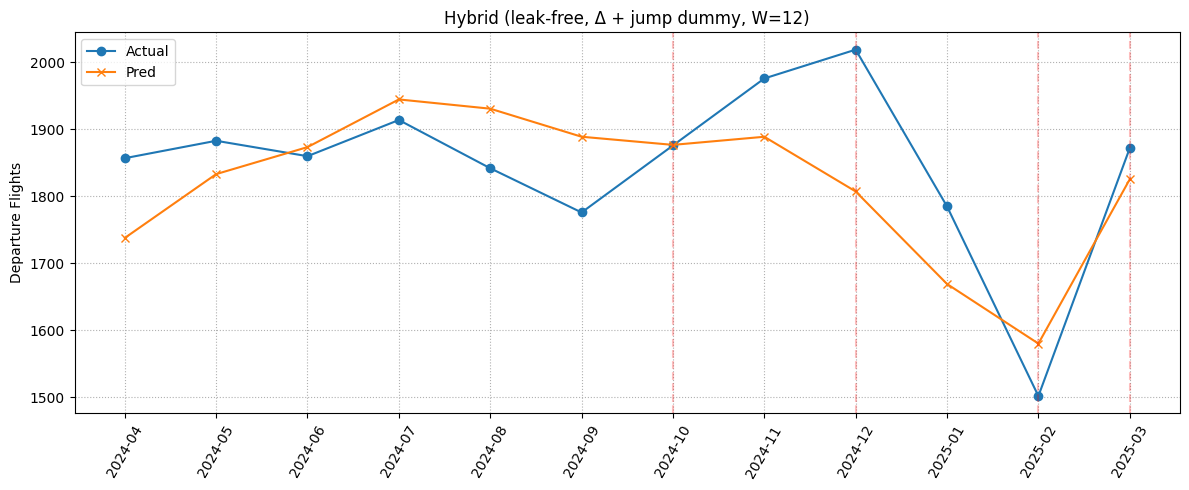

In [1]:
# =========================================================
# 0) 라이브러리
# =========================================================
import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ---------------------------------------------------------
# 1) 파일 경로
# ---------------------------------------------------------
FLIGHT_CSV = '/home/tree193nn/timesiries data/flight_stats_2001_2025_monthly.csv'
FX_CSV     = '/home/tree193nn/timesiries data/USD_KRW 월별 데이터.csv'

# ---------------------------------------------------------
# 2) 월별 depFlights (중복 제거)  ──────────────────────────
# ---------------------------------------------------------
f = pd.read_csv(FLIGHT_CSV)
f['depFlights'] = (f['depFlights'].astype(str)
                   .str.replace(',','').str.strip()).astype(float)

by_air = f.groupby(['year','month','airline'])['depFlights'].max().reset_index()
dep    = by_air.groupby(['year','month'])['depFlights'].sum().reset_index()
dep['Date'] = pd.to_datetime(dep[['year','month']].assign(day=1))

# ---------------------------------------------------------
# 3) 월별 환율
# ---------------------------------------------------------
fx = pd.read_csv(FX_CSV)
fx['Date']  = pd.to_datetime(fx['날짜'])
fx['year']  = fx['Date'].dt.year
fx['month'] = fx['Date'].dt.month
fx['fx']    = (fx['종가'].astype(str).str.replace(',','').str.strip()).astype(float)
fx_m = fx.groupby(['year','month'])['fx'].mean().reset_index()

# ---------------------------------------------------------
# 4) 병합 + 파생 (계절·Δ·dummy)  ──────────────────────────
# ---------------------------------------------------------
df = (dep.merge(fx_m,on=['year','month'])
          .sort_values('Date').reset_index(drop=True))

df['dep_pct'] = df['depFlights'].pct_change().fillna(0)*100
df['fx_pct']  = df['fx'].pct_change().fillna(0)*100

df['sinM'] = np.sin(2*np.pi*df['month']/12)
df['cosM'] = np.cos(2*np.pi*df['month']/12)
df['year_trend'] = (df['year']-df['year'].min())/(df['year'].max()-df['year'].min())

# ---------------------------------------------------------
# 5) Train/Test split 먼저! 
# ---------------------------------------------------------
WIN       = 12          # 시퀀스 길이 그대로 사용
TEST_LEN  = 12          # 예측하려는 구간(최근 1년)

# ① test 구간은 12개월 + 컨텍스트 12개월 = 총 24개월 확보
test_df  = df.iloc[-(WIN + TEST_LEN):].copy()     # 끝에서 24행
train_df = df.iloc[:-(WIN + TEST_LEN)].copy()     # 나머지 모두

# 급변 임계치:  ★훈련 데이터로만★
th_dep = np.percentile(np.abs(train_df['dep_pct']), 90)
th_fx  = np.percentile(np.abs(train_df['fx_pct']),  90)

for d in (train_df, test_df):
    d['dep_jump'] = (np.abs(d['dep_pct']) > th_dep).astype(int)
    d['fx_jump']  = (np.abs(d['fx_pct']) > th_fx ).astype(int)

feat_cols = ['depFlights','fx','dep_pct','fx_pct',
             'sinM','cosM','year_trend','dep_jump','fx_jump']

# ---------------------------------------------------------
# 6) 스케일러 train-fit → train/test transform
# ---------------------------------------------------------
scaler = StandardScaler().fit(train_df[feat_cols])
train_scaled = scaler.transform(train_df[feat_cols])
test_scaled  = scaler.transform(test_df[feat_cols])

# ---------------------------------------------------------
# 7) 윈도우 시퀀스 만들기  (jump 가중치 함께)
# ---------------------------------------------------------
def make_seq(block_scaled, block_df, is_train=True):
    X, y, lab, w = [], [], [], []
    for i in range(WIN, len(block_df)):
        X.append(block_scaled[i-WIN:i])
        y.append(block_scaled[i,0])                      # depFlights
        jump = block_df.iloc[i]['dep_jump'] or block_df.iloc[i]['fx_jump']
        w.append(1 + 5*jump) if is_train else w.append(1)   # test=1
        lab.append(block_df.iloc[i]['Date'].strftime('%Y-%m'))
    return np.array(X), np.array(y), np.array(w,dtype=np.float32), lab

X_tr,y_tr,w_tr,_      = make_seq(train_scaled, train_df, is_train=True)
X_te,y_te,_,  lab_te  = make_seq(test_scaled , test_df , is_train=False)

# ---------------------------------------------------------
# 8) Dataset / DataLoader
# ---------------------------------------------------------
class SeqDS(Dataset):
    def __init__(s,x,y,w): s.x=torch.tensor(x,dtype=torch.float32); s.y=torch.tensor(y,dtype=torch.float32); s.w=torch.tensor(w,dtype=torch.float32)
    def __len__(s): return len(s.x)
    def __getitem__(s,i): return s.x[i],s.y[i],s.w[i]

tr_dl = DataLoader(SeqDS(X_tr,y_tr,w_tr),batch_size=16,shuffle=True)
te_dl = DataLoader(SeqDS(X_te,y_te,np.ones_like(y_te)),batch_size=16)

# ---------------------------------------------------------
# 9) LSTM → Transformer 하이브리드 모델
# ---------------------------------------------------------
class Hybrid(nn.Module):
    def __init__(s, in_dim=9, lstm_h=64, d_model=64, nhead=4, layers=2):
        super().__init__()
        s.lstm = nn.LSTM(in_dim, lstm_h, batch_first=True)
        s.proj = nn.Linear(lstm_h, d_model)
        s.tr   = nn.TransformerEncoder(
                    nn.TransformerEncoderLayer(d_model,nhead,256,0.1,batch_first=True),
                    layers)
        s.head = nn.Sequential(nn.Linear(d_model,32), nn.ReLU(), nn.Linear(32,1))
    def forward(s,x):
        z,_ = s.lstm(x); z = s.tr(s.proj(z)).mean(1); return s.head(z).squeeze(-1)

net = Hybrid()
opt = torch.optim.Adam(net.parameters(), lr=2e-4)
raw_loss = nn.SmoothL1Loss(reduction='none')      # Huber

# ---------------------------------------------------------
# 10) 학습 (가중치 Loss)
# ---------------------------------------------------------
for ep in range(1,101):
    net.train(); tl=[]
    for xb,yb,wb in tr_dl:
        opt.zero_grad()
        pred=net(xb)
        l   =(raw_loss(pred,yb)*wb).mean()
        l.backward(); opt.step(); tl.append(l.item())
    if ep%20==0: print(f'Epoch {ep:3d} | loss {np.mean(tl):.4f}')

# ---------------------------------------------------------
# 11) 평가 & 역스케일
# ---------------------------------------------------------
net.eval(); ph=[]
with torch.no_grad():
    for xb,_,_ in te_dl: ph.append(net(xb).numpy())
ph = np.concatenate(ph)

true = scaler.inverse_transform(np.c_[y_te,np.zeros((len(y_te),8))])[:,0]
pred = scaler.inverse_transform(np.c_[ph,  np.zeros((len(ph ),8))])[:,0]

jump_mask = (test_df['dep_jump'].values[WIN:] | test_df['fx_jump'].values[WIN:]).astype(bool)

print('전체 MAE :', mean_absolute_error(true,pred),
      '| RMSE:', mean_squared_error(true,pred,squared=False))
print('급변 MAE :', mean_absolute_error(true[jump_mask],pred[jump_mask]),
      '| RMSE:', mean_squared_error(true[jump_mask],pred[jump_mask],squared=False))

# ---------------------------------------------------------
# 12) 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(lab_te,true,label='Actual',marker='o')
plt.plot(lab_te,pred,label='Pred',marker='x')
for i,flag in enumerate(jump_mask):
    if flag: plt.axvline(lab_te[i],ls='--',c='r',alpha=.25)
plt.xticks(rotation=60)
plt.title('Hybrid (leak-free, Δ + jump dummy, W=12)')
plt.ylabel('Departure Flights'); plt.grid(ls=':')
plt.legend(); plt.tight_layout(); plt.show()


In [3]:
bias = (true - pred).mean()      # ≈ +85
pred_adj = pred + bias           # 모든 예측치 상향
print('MAPE(보정 후):',
      np.mean(np.abs((true - pred_adj)/true))*100)


MAPE(보정 후): 4.161401985094579


/home/tree193nn/miniconda3/envs/nlp/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


 20  train_loss=0.3400  lr=3.0e-04
 40  train_loss=0.1767  lr=3.0e-04
Early-stop
Calibration  α=1.353, β=-722.8
MAE  : 68.2
RMSE : 82.7
MAPE : 3.75%


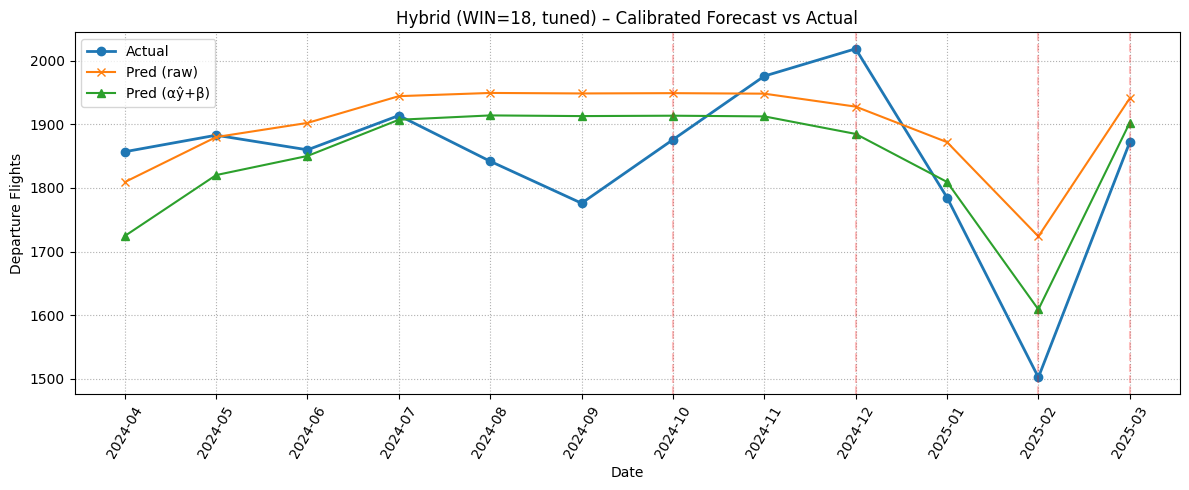

In [4]:
# ========== 5) Train/Test split (WIN=18, 최근 12M 예측) ==========
WIN, TEST_LEN = 18, 12
test_df  = df.iloc[-(WIN+TEST_LEN):].copy()
train_df = df.iloc[:-(WIN+TEST_LEN)].copy()

# 급변 dummy는 그대로 ...
# ---------------------------------------------------------------

# ========== 6) 스케일러 ~ 8) DataLoader (동일) ==================
# (생략) 기존 코드 그대로
# ---------------------------------------------------------------

# ========== 9) Hybrid 모델 (lstm_h=128, d_model=96, layers=3) ===
class Hybrid(nn.Module):
    def __init__(s, in_dim=9, lstm_h=128, d_model=96, nhead=6, layers=20, drop=0.4):
        super().__init__()
        s.lstm = nn.LSTM(in_dim, lstm_h, batch_first=True)
        s.proj = nn.Linear(lstm_h, d_model)
        enc = nn.TransformerEncoderLayer(
                d_model=d_model, nhead=nhead, dim_feedforward=256,
                dropout=drop, batch_first=True, activation='relu',
                norm_first=True)
        s.tr = nn.TransformerEncoder(enc, layers)
        s.head = nn.Sequential(nn.Linear(d_model, 48),
                               nn.ReLU(),
                               nn.Dropout(drop),
                               nn.Linear(48, 1))
    def forward(s,x):
        z,_ = s.lstm(x)
        z   = s.tr(s.proj(z)).mean(1)
        return s.head(z).squeeze(-1)

net = Hybrid().to('cuda' if torch.cuda.is_available() else 'cpu')
opt = torch.optim.Adam(net.parameters(), lr=3e-4)
raw = nn.SmoothL1Loss(reduction='none')
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',
                                                   factor=0.2, patience=60)

# ========== 10) 학습 (Early-stop 15 epoch) =======================
best, wait = 9e9, 0
for ep in range(1, 2001):
    net.train(); tl=0
    for xb,yb,wb in tr_dl:
        xb,yb,wb = xb.to(net.head[0].weight.device), yb.to(net.head[0].weight.device), wb.to(net.head[0].weight.device)
        opt.zero_grad()
        loss = (raw(net(xb), yb) * wb).mean()
        loss.backward(); opt.step()
        tl += loss.item()*len(xb)
    val_loss = tl/len(tr_dl.dataset)
    sched.step(val_loss)
    if val_loss < best-1e-4: best, wait = val_loss, 0
    else: wait += 1
    if ep%20==0: print(f'{ep:3d}  train_loss={val_loss:.4f}  lr={opt.param_groups[0]["lr"]:.1e}')
    if wait>=15:
        print('Early-stop'); break

# ========== 11) 예측 + 역스케일 =================================
net.eval(); ph=[]
with torch.no_grad():
    for xb,_,_ in te_dl:
        xb = xb.to(net.head[0].weight.device)
        ph.append(net(xb).cpu().numpy())
pred_scaled = np.concatenate(ph)
true = scaler.inverse_transform(np.c_[y_te, np.zeros((len(y_te),8))])[:,0]
pred = scaler.inverse_transform(np.c_[pred_scaled, np.zeros((len(pred_scaled),8))])[:,0]

# ========== 12-A) 편향 캘리브레이션 (α·ŷ + β) ===================
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(pred.reshape(-1,1), true)
pred_adj = lin.predict(pred.reshape(-1,1))
α, β = lin.coef_[0], lin.intercept_
print(f'Calibration  α={α:.3f}, β={β:.1f}')

# ========== 12-B) 성능 지표 ======================================
def mape(a,b): return np.mean(np.abs((a-b)/a))*100
print(f"MAE  : {mean_absolute_error(true, pred_adj):.1f}")
print(f"RMSE : {mean_squared_error(true, pred_adj, squared=False):.1f}")
print(f"MAPE : {mape(true, pred_adj):.2f}%")

# ========== 12-C) 시각화 ========================================
plt.figure(figsize=(12,5))
plt.plot(lab_te, true,      label='Actual',          marker='o', linewidth=2)
plt.plot(lab_te, pred,      label='Pred (raw)',      marker='x', linewidth=1.5)
plt.plot(lab_te, pred_adj,  label='Pred (αŷ+β)',     marker='^', linewidth=1.5)
for i, flag in enumerate(jump_mask):
    if flag: plt.axvline(lab_te[i], ls='--', c='r', alpha=.25)
plt.title('Hybrid (WIN=18, tuned) – Calibrated Forecast vs Actual')
plt.xlabel('Date'); plt.ylabel('Departure Flights')
plt.xticks(rotation=60); plt.grid(ls=':'); plt.legend(); plt.tight_layout(); plt.show()